In [ ]:
import numpy as np 
import cv2 
from PIL import Image 
import matplotlib.pyplot as plt 
import matplotlib.animation as animate
import torch 
import time 
from torchvision import models, transforms 
from typing import Union 
from glob import glob 

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)
def load_model():
    model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    model.to(device)
    model.eval()
    return model 

transform = transforms.Compose([
                                transforms.ToTensor(),
])

def inference(image):
    '''予測する'''
    with torch.no_grad():
        results = model(image)
    return results 

model = load_model()

In [ ]:
def detect():
    '''物体検出'''
    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ims = []
    for f in glob("./img/*.jpg"):
        img = Image.open(f)
        img_tensor = transform(img).unsqueeze(0).to(device)
        res = inference(img_tensor)
        bbox = res[0]
        img = np.array(img, dtype=np.uint8) # cv2での読み込み形式
        for box, label, score in zip(bbox["boxes"], bbox["labels"], bbox["scores"]):
            box = box.detach().cpu().numpy()
            label = label.item()
            score = score.item()
            if score > 0.5 and label in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
                pos1 = (int(box[0]), int(box[1])) # (xmin, ymin)
                pos2 = (int(box[2]), int(box[3])) # (xmax, ymax)

                img = cv2.rectangle(img, pos1, pos2, (0, 0, 192), label)
        img = img[:, :, ::-1]
        im = plt.imshow(img, animated=True)
        plt.xticks([])
        plt.yticks([])
        ims.append([im])

    ani = animate.ArtistAnimation(fig, ims, interval=300, blit=True, repeat_delay=2000)
    ani.save("detection.mp4", writer="ffmpeg")
    plt.show()


def segment():
    '''セグメンテーション'''
    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ims = []
    for f in glob("./img/*.jpg"):
        img = Image.open(f)
        img_tensor = transform(img).unsqueeze(0).to(device)
        res = inference(img_tensor)
        bbox = res[0]
        img = np.array(img, dtype=np.uint8)
        masks = None 
        for score, mask in zip(bbox["scores"], bbox["masks"]):
            score = score.item()
            if score > 0.5:
                if masks is None:
                    masks = mask 
                else:
                    masks = torch.max(masks, mask) # 後から読み込みされるピクセルを上書きする
        if masks is None: continue
        masks = masks[0].cpu().numpy() # (w, h, c)
        im = plt.imshow(masks, animated=True)
        plt.xticks([])
        plt.yticks([])
        ims.append([im])

    ani = animate.ArtistAnimation(fig, ims, interval=300, blit=True, repeat_delay=2000)
    ani.save("segmentation.mp4", writer="ffmpeg")
    plt.show()


def main():
    if types == "segment":
        segment()
    elif types == "detect":
        detect()

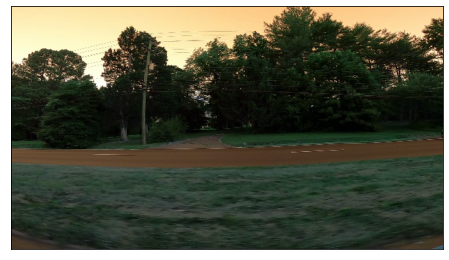

In [ ]:
types = "detect"
main()

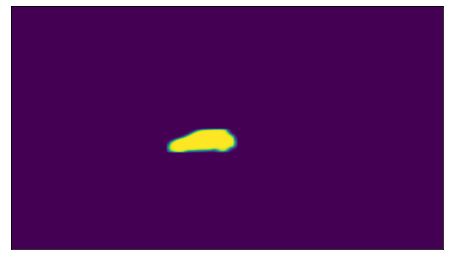

In [ ]:
types = "segment"
main()